In [1]:
import sys
sys.path.insert(0, '../../..')
from cgi import test
from multiprocessing.sharedctypes import Value
from yaml import parse
import glob
import warnings
import requests
import dateutil
import pytz
import traceback
import pandas            as pd
import pandas_ta         as ta
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mlfinlab          as fml
from   mlfinlab                  import sample_weights
from   mlfinlab.cross_validation import CombinatorialPurgedKFold
import pyfolio           as pf
from   scipy.stats       import norm
from   backtesting       import Backtest, Strategy
from   backtesting.lib   import crossover

from   sklearn.metrics import roc_curve
from   sklearn.metrics import classification_report
from   sklearn.metrics import confusion_matrix
from   sklearn.metrics import accuracy_score
from   sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,12)

/home/sharav/src/portfolio-xm/env/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# loading history with features...
print("reading dataset...")

df = pd.read_csv("../../../data/BTCUSDT/BTCUSDT-features-1m.csv", parse_dates=True, index_col="timestamp")

df

reading dataset...


,op,hi,lo,cl,volume,m_rsi,m_roc,m_wr,vm_cmf,vm_mfi,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-18 04:02:00+00:00,4292.39,4292.39,4292.39,4292.39,0.163824,58.204862,-0.097984,-15.292408,0.730069,70.892627,...,-0.846987,-0.974818,1,-0.417726,0.887136,-3.622000,-9.903640,-1.352286,-0.174593,5.412000
2017-08-18 04:04:00+00:00,4269.26,4269.26,4269.26,4269.26,0.988305,38.387955,-0.440284,-99.185249,0.636822,42.520834,...,-0.999636,-0.687760,0,1.146701,0.880253,16.873143,-13.129643,19.905429,-0.233253,9.252000
2017-08-18 04:05:00+00:00,4269.01,4269.01,4269.01,4269.01,0.557007,38.236424,-0.446114,-100.000000,0.626582,40.226107,...,-0.779648,-0.108492,0,1.000000,0.863521,12.400286,-36.856195,22.145429,-0.749626,11.392851
2017-08-18 04:07:00+00:00,4269.01,4269.01,4269.01,4269.01,0.591960,38.236424,-0.446346,-100.000000,0.682004,40.226107,...,-0.652191,0.074857,0,1.000000,0.808468,4.594286,-56.833464,24.485714,-1.530110,9.327503
2017-08-18 04:08:00+00:00,4269.01,4269.01,4269.01,4269.01,0.339186,38.236424,-0.446346,-100.000000,0.650170,37.361274,...,-0.694225,0.018055,0,1.000000,0.758373,1.512571,-60.862617,24.833143,-1.793890,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10 03:59:00+00:00,19451.27,19453.96,19450.38,19452.99,21.652750,56.802230,0.071917,-8.819658,0.122910,71.095889,...,0.607934,-0.131559,0,1.784075,0.837175,1.696571,47.658417,-12.569429,1.097385,1.399807
2022-10-10 04:00:00+00:00,19452.97,19452.99,19441.06,19444.70,134.439800,46.282289,0.003343,-56.008700,0.073632,56.540301,...,0.401330,-0.363880,0,2.713026,0.810902,7.940857,35.492626,-1.329429,0.713099,3.236260
2022-10-10 04:01:00+00:00,19443.89,19448.31,19441.93,19442.37,50.338190,43.825537,-0.025608,-70.835670,0.057582,50.091731,...,0.307295,-0.455602,0,-0.272117,0.782850,7.536571,14.333334,4.214857,0.255516,4.648739


In [3]:
# Helper functions

def get_daily_volatility(close, lookback=100):
    # daily vol re-indexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
    df0 = close.loc[df0.index] / close.loc[df0.array].array - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

def cci_indicator(df_, length=40):
    hlc3 = (df_['hi']+df_['lo']+df_['cl'])/3
    sma  = hlc3.rolling(length).mean()
    mad  = hlc3.rolling(length).apply(lambda x: pd.Series(x).mad())
    cci  = (hlc3-sma)/(0.015*mad)
    cci_smooth = cci.ewm(span=5, min_periods=0, adjust=False, ignore_na=False).mean()
    return cci, cci_smooth

In [4]:
# CCI signal extraction

timeframe = 5

d = {
    'op'    : 'first', 
    'hi'    : 'max'  ,
    'lo'    : 'min'  ,
    'cl'    : 'last' ,
    'volume': 'sum'
    }
df_xm = df.resample(f"{timeframe}Min").agg(d)

df_xm['cci'], _ = cci_indicator(df_xm)
df_xm.dropna(inplace=True)

upper_threshold =  232.4135
lower_threshold = -232.4135

df_xm['position'] = 0
df_xm.loc[(df_xm['cci'].shift(1)<upper_threshold)&(df_xm['cci']>=upper_threshold), 'position'] = -1
df_xm.loc[(df_xm['cci'].shift(1)>lower_threshold)&(df_xm['cci']<=lower_threshold), 'position'] =  1

# saving signals to market state
df['position'] = 0
for idx, row in df_xm[(df_xm['position']==1)|(df_xm['position']==-1)].iterrows():
    if idx in df.index:
        df.loc[idx, 'position'] = row.position

# removing look-ahead bias by lagging signal
df['position'] = df['position'].shift(timeframe+1)

df.dropna(inplace=True)

In [5]:
# Daily volatility calculation which is helpful for defining tp and sl levels

w = 840 # 14 hours
df['volatility_tpsl'] = fml.util.get_daily_vol(close=df['cl'], lookback=w)

In [6]:
# TBL labeling testing set

RR        = 1.0
sl_target = 0.7
pt_sl     = [round(sl_target*RR,2), sl_target]

print(f"{RR} -> {pt_sl}")

min_ret = 0.001

signal_indexes = df[(df['position']==1)|(df['position']==-1)].index
signal_sides   = df[(df['position']==1)|(df['position']==-1)]['position']

vertical_barriers = fml.labeling.add_vertical_barrier(
    t_events = signal_indexes, 
    close    = df['cl'], 
    num_days = 2
)
triple_barriers = fml.labeling.get_events(
    close                  = df['cl']             ,
    t_events               = signal_indexes       ,
    pt_sl                  = pt_sl                ,
    target                 = df['volatility_tpsl'],
    min_ret                = min_ret              ,
    num_threads            = 1                    ,
    vertical_barrier_times = vertical_barriers    ,
    side_prediction        = signal_sides
)
meta_labels = fml.labeling.get_bins(triple_barriers, df['cl'])

# Primary testing signal accuracy

primary_forecast = pd.DataFrame(meta_labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

actual = primary_forecast['actual']
pred   = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

1.0 -> [0.7, 0.7]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3842
           1       0.52      1.00      0.68      4102

    accuracy                           0.52      7944
   macro avg       0.26      0.50      0.34      7944
weighted avg       0.27      0.52      0.35      7944

Confusion Matrix
[[   0 3842]
 [   0 4102]]

Accuracy
0.5163645518630413


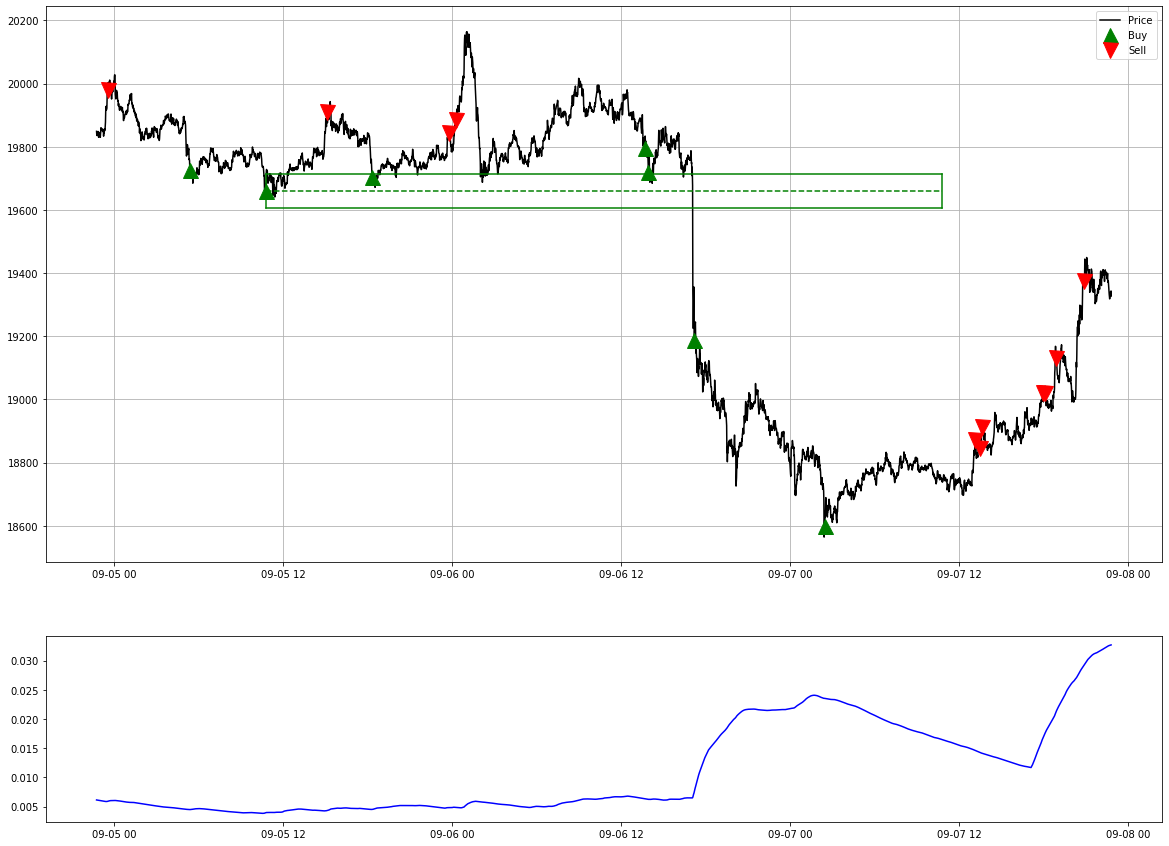

In [7]:
# Plotting buy side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = meta_labels[(meta_labels['bin']==1)&(meta_labels['side']==1)].sample()
selected_date = label.index[0]

frame_start   = pd.to_datetime(selected_date - pd.Timedelta(seconds=43200 ), unit='s', utc=True) # 12 hours
frame_end     = pd.to_datetime(selected_date + pd.Timedelta(seconds=216000), unit='s', utc=True) # 2 days 12 hours

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = pd.to_datetime(selected_date, unit='s', utc=True)
event_end   = pd.to_datetime(selected_date+pd.Timedelta(seconds=172800), unit='s', utc=True) # 2 days

close_price = df.loc[df.index==selected_date]['cl'].values[-1]
price_0     = np.exp(np.log(close_price)+df['volatility_tpsl'][event_start]*pt_sl[0])
price_1     = np.exp(np.log(close_price)-df['volatility_tpsl'][event_start]*pt_sl[1])

df_plot = df_
axs[0].plot(df_plot['cl'], color='k', label='Price')
axs[0].plot(
    df_plot[df_plot['position']==1].index,
    df_plot['cl'][df_plot['position']==1],
    '^', markersize=15, color='g', label='Buy'
)
axs[0].plot(
    df_plot[df_plot['position']==-1].index,
    df_plot['cl'][df_plot['position']==-1],
    'v', markersize=15, color='r', label='Sell'
)

axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_0    , price_0    ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [price_1    , price_1    ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='g')
axs[0].plot([event_start, event_start], [price_1    , price_0    ], 'r-' , color='g')
axs[0].plot([event_end  , event_end  ], [price_1    , price_0    ], 'r-' , color='g')

axs[1].plot(df_plot['volatility_tpsl'], color='b', label="daily volatility")

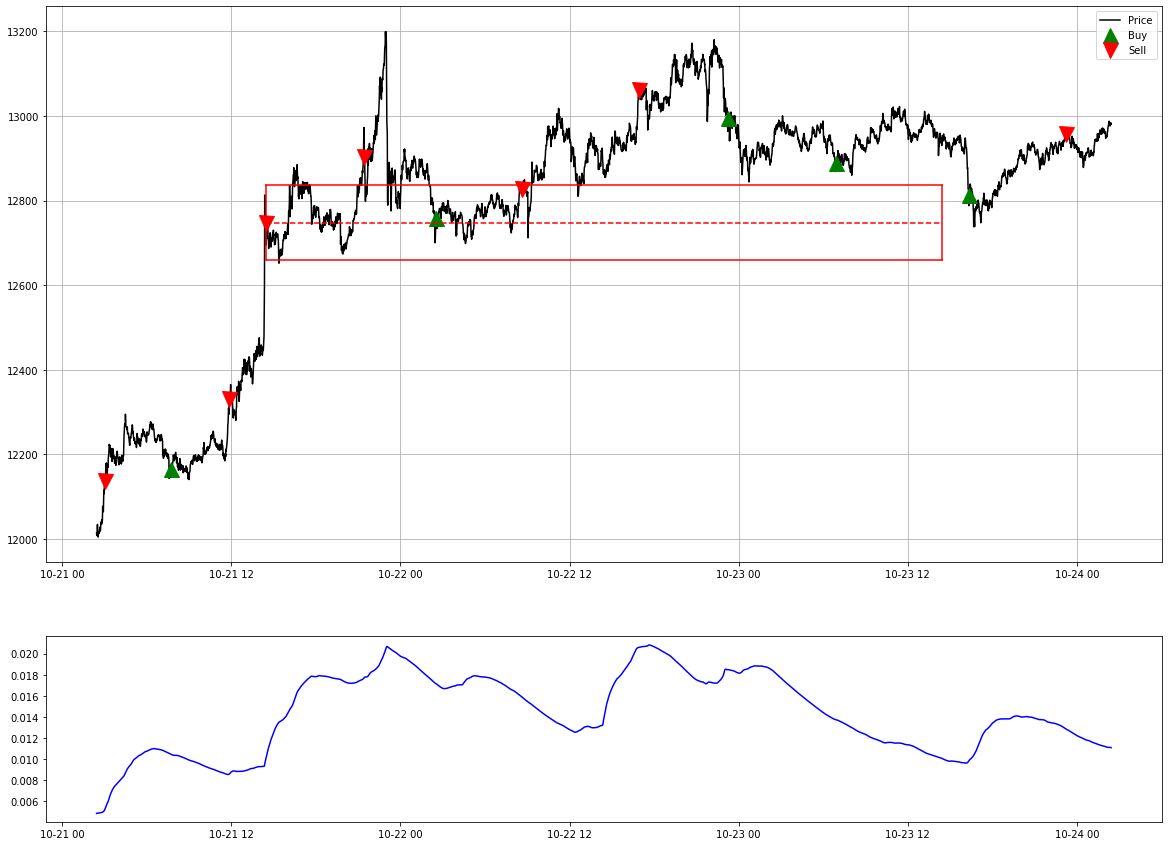

In [8]:
# Plotting sell side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = meta_labels[(meta_labels['bin']==1)&(meta_labels['side']==-1)].sample()
selected_date = label.index[0]

frame_start   = pd.to_datetime(selected_date - pd.Timedelta(seconds=43200 ), unit='s', utc=True) # 12 hours
frame_end     = pd.to_datetime(selected_date + pd.Timedelta(seconds=216000), unit='s', utc=True) # 2 days 12 hours

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = pd.to_datetime(selected_date, unit='s', utc=True)
event_end   = pd.to_datetime(selected_date+pd.Timedelta(seconds=172800), unit='s', utc=True) # 2 days

close_price = df.loc[df.index==selected_date]['cl'].values[-1]
price_0     = np.exp(np.log(close_price)+df['volatility_tpsl'][event_start]*pt_sl[1])
price_1     = np.exp(np.log(close_price)-df['volatility_tpsl'][event_start]*pt_sl[0])

df_plot = df_
axs[0].plot(df_plot['cl'], color='k', label='Price')
axs[0].plot(
    df_plot[df_plot['position']==1].index,
    df_plot['cl'][df_plot['position']==1],
    '^', markersize=15, color='g', label='Buy'
)
axs[0].plot(
    df_plot[df_plot['position']==-1].index,
    df_plot['cl'][df_plot['position']==-1],
    'v', markersize=15, color='r', label='Sell'
)

axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_0    , price_0    ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [price_1    , price_1    ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='r')
axs[0].plot([event_start, event_start], [price_1    , price_0    ], 'r-' , color='r')
axs[0].plot([event_end  , event_end  ], [price_1    , price_0    ], 'r-' , color='r')

axs[1].plot(df_plot['volatility_tpsl'], color='b', label="daily volatility")

In [9]:
# combinatorial purged cross validation and warm them up

X_train = df.loc[meta_labels.index]
y_train = meta_labels['bin']

n_split      = 10
n_test_split = 2

info_sets = triple_barriers.loc[X_train.index].t1

cv_gen = fml.cross_validation.CombinatorialPurgedKFold(
    n_splits          = n_split,
    n_test_splits     = n_test_split,
    samples_info_sets = info_sets,
    pct_embargo       = 0.01
)

# warpup for path information
for train_idxs, test_idxs in cv_gen.split(X=X_train, y=y_train):
    pass

print(f"total paths : {len(cv_gen.backtest_paths)}")

total paths : 9


In [10]:
# Analyzing average testing periods by weeks

dt_list = []

for cv_path_set in cv_gen.backtest_paths:
    for cv_path in cv_path_set:
        test_dates = []
        for test_idx in cv_path['test']:
            test_dates.append(info_sets.iloc[test_idx])
        test_min_date = pd.to_datetime(min(test_dates))
        test_max_date = pd.to_datetime(max(test_dates))

        delta_time = pd.Timedelta(test_max_date - test_min_date)
        dt_list.append(int(delta_time.days/7))
        print(f"{delta_time} {int(delta_time.days/7)} weeks")

dt_list = np.array(dt_list)
dt_df   = pd.DataFrame()
dt_df['dt'] = dt_list

245 days 15:41:00 35 weeks
159 days 18:25:00 22 weeks
171 days 13:25:00 24 weeks
179 days 05:27:00 25 weeks
174 days 07:06:00 24 weeks
180 days 10:48:00 25 weeks
193 days 14:30:00 27 weeks
199 days 08:08:00 28 weeks
186 days 13:55:00 26 weeks
181 days 09:48:00 25 weeks
245 days 15:41:00 35 weeks
159 days 18:25:00 22 weeks
171 days 13:25:00 24 weeks
179 days 05:27:00 25 weeks
174 days 07:06:00 24 weeks
180 days 10:48:00 25 weeks
193 days 14:30:00 27 weeks
199 days 08:08:00 28 weeks
186 days 13:55:00 26 weeks
181 days 09:48:00 25 weeks
245 days 15:41:00 35 weeks
159 days 18:25:00 22 weeks
171 days 13:25:00 24 weeks
179 days 05:27:00 25 weeks
174 days 07:06:00 24 weeks
180 days 10:48:00 25 weeks
193 days 14:30:00 27 weeks
199 days 08:08:00 28 weeks
186 days 13:55:00 26 weeks
181 days 09:48:00 25 weeks
245 days 15:41:00 35 weeks
159 days 18:25:00 22 weeks
171 days 13:25:00 24 weeks
179 days 05:27:00 25 weeks
174 days 07:06:00 24 weeks
180 days 10:48:00 25 weeks
193 days 14:30:00 27 weeks
1

<AxesSubplot:>

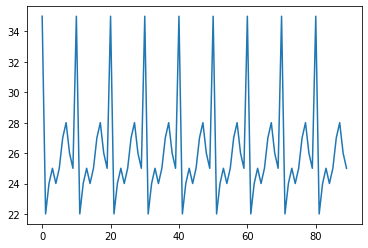

In [11]:
# testing range periods by weeks
dt_df['dt'].plot()

In [12]:
# Annualized Sharpe Ratio
def annualized_sharpe_ratio(returns, periods=252):
    estimated_sharpe_ratio = returns.mean()/returns.std(ddof=1)
    return estimated_sharpe_ratio*np.sqrt(periods)

In [13]:
# Eval data preparation

df = df.rename(columns={
    "op"    : "Open" , 
    "hi"    : "High" ,
    "lo"    : "Low"  ,
    "cl"    : "Close",
    })
df["Volume"] = df["volume"]

df_ = df[['Open', 'High', 'Low', 'Close', 'Volume', 'volatility_tpsl', 'position']]

df_

,Open,High,Low,Close,Volume,volatility_tpsl,position
timestamp,,,,,,,
2017-08-18 04:11:00+00:00,4266.56,4266.56,4266.56,4266.56,0.546770,NaN,0.0
2017-08-18 04:12:00+00:00,4266.56,4266.56,4266.56,4266.56,0.219889,NaN,0.0
2017-08-18 04:13:00+00:00,4258.27,4266.56,4252.01,4252.01,3.797227,NaN,0.0
2017-08-18 04:14:00+00:00,4252.01,4252.01,4252.01,4252.01,0.555117,NaN,0.0
2017-08-18 04:16:00+00:00,4266.56,4266.56,4247.93,4247.93,1.421804,NaN,0.0
...,...,...,...,...,...,...,...
2022-10-10 03:59:00+00:00,19451.27,19453.96,19450.38,19452.99,21.652750,0.003802,0.0
2022-10-10 04:00:00+00:00,19452.97,19452.99,19441.06,19444.70,134.439800,0.003799,0.0
2022-10-10 04:01:00+00:00,19443.89,19448.31,19441.93,19442.37,50.338190,0.003795,0.0


In [14]:
# Sharpe Ratio collections from testing paths

binance_commission = 0.001

class CCIRawStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        price      = self.data.Close[-1]
        volatility = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==1:
            price_tp = np.exp(np.log(price)+volatility*pt_sl[0])
            price_sl = np.exp(np.log(price)-volatility*pt_sl[1])
            if price_sl<price and price<price_tp:
                self.buy(size=0.1, sl=price_sl, tp=price_tp)
        if self.data.position[-1]==-1:
            price_sl = np.exp(np.log(price)+volatility*pt_sl[1])
            price_tp = np.exp(np.log(price)-volatility*pt_sl[0])
            if price_sl>price and price>price_tp:
                self.sell(size=0.1, sl=price_sl, tp=price_tp)


sharpe_ratio_list = []
for cv_path_set in cv_gen.backtest_paths:
    for cv_path in cv_path_set:
        train_dates = []
        for train_idx in cv_path['train']:
            train_dates.append(info_sets.iloc[train_idx])
        train_min_date = min(train_dates)
        train_max_date = max(train_dates)

        test_dates = []
        for test_idx in cv_path['test']:
            test_dates.append(info_sets.iloc[test_idx])
        test_min_date = min(test_dates)
        test_max_date = max(test_dates)

        bt = Backtest(
            df_[test_min_date:test_max_date], 
            CCIRawStrategy, 
            cash             = 100000000, 
            commission       = binance_commission, 
            exclusive_orders = True
        )
        stats = bt.run()
        stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
        stats_df = stats_df.set_index('EntryTime')
        estimated_sr = annualized_sharpe_ratio(stats_df["ReturnPct"])
        sharpe_ratio_list.append(estimated_sr)
        print(f"{test_min_date} : {test_max_date}, SR={estimated_sr}")

2017-08-22 12:55:00+00:00 : 2018-04-25 04:36:00+00:00, SR=0.9736469602787419
2018-04-25 23:29:00+00:00 : 2018-10-02 17:54:00+00:00, SR=-0.7542604541480671
2018-10-02 23:55:00+00:00 : 2019-03-23 13:20:00+00:00, SR=-0.0049841140452201275
2019-03-23 20:34:00+00:00 : 2019-09-19 02:01:00+00:00, SR=-2.0238352942377302
2019-09-19 03:07:00+00:00 : 2020-03-11 10:13:00+00:00, SR=-0.5085083523336881
2020-03-11 10:13:00+00:00 : 2020-09-07 21:01:00+00:00, SR=-1.5339121856890559
2020-09-07 22:50:00+00:00 : 2021-03-20 13:20:00+00:00, SR=-0.9312102429283002
2021-03-20 11:42:00+00:00 : 2021-10-05 19:50:00+00:00, SR=-0.4945474564062703
2021-10-06 08:35:00+00:00 : 2022-04-10 22:30:00+00:00, SR=-0.24680021342230643
2022-04-11 09:44:00+00:00 : 2022-10-09 19:32:00+00:00, SR=-0.8327335499737447
2017-08-22 12:55:00+00:00 : 2018-04-25 04:36:00+00:00, SR=0.9736469602787419
2018-04-25 23:29:00+00:00 : 2018-10-02 17:54:00+00:00, SR=-0.7542604541480671
2018-10-02 23:55:00+00:00 : 2019-03-23 13:20:00+00:00, SR=-0.0

In [15]:
sr_df = pd.DataFrame()
sr_df['sr'] = sharpe_ratio_list

Mean Sharpe Ratio : -0.635714490290564


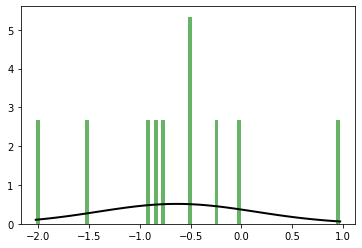

In [25]:
from scipy.stats import norm

fig, axs = plt.subplots(1)

xmin = sr_df['sr'].values.min()
xmax = sr_df['sr'].values.max()
bins = 80

mu, sigma = norm.fit(sr_df['sr'].values)

x = np.linspace(xmin, xmax, bins)
p = norm.pdf(x, mu, sigma)

axs.hist(sr_df['sr'].values, bins=80, density=True, alpha=0.6, color='g')
axs.plot(x, p, 'k', linewidth=2)

print(f"Mean Sharpe Ratio : {mu}")